# Data ingestion and formatting

This notebook explains how to convert the Climate TRACE dataset to a format that is more appropriate for data science. 

```{note}
This section is relevant for data engineers, or data scientists who want to understand how the data 
has been prepared. Skip if you just want to access the final, prepared data.
```

The original data from Climate TRACE is offered as a series of CSV files bundled in ZIP archives. That format is universally understood, but it is not the most effective for effective analysis with data science tools. In particular, it is large: the source data, uncompressed, is about 100GB for each gas! This is the size at which most people would consider this project to be "big data" or at least "medium data". With the proper choice of data storage, we will bring it down to a breezy "small data" without losing information along the way.

Instead, we are going to use the Parquet format. This format has a number of advantages:
- it is _column-based_ : data systems can process big chunks of data at once, rather than line by line. Also, depending on the information requested, systems will read only the relevant columns and skip the rest very effectively
- it is _universal_ : most modern data systems will be able to read it.
- it is _structured_ : basic information about numbers, categories, ... are preserved.


Looking at the code, we are performing a few tricks:

_Compacting the data_ We minimize the size of the files by taking advantage of its structures. In particular, we know in many cases that values are part of known enumerations (sectors, ...). We replace all these by `polars.Enumeration`s. Not only this makes files smaller, but it also allows data systems to make clever optimization for complex operations such as joining.

_Lazy reading_ If we were to read all the source data using a traditional system such as Excel or Pandas, we would require a serious amount of memory. The files themselves are more than 5GB. Polars is capable of reading straight from the zip file in a streaming fashion. This is what Polars calls a Lazy dataframe, or LazyFrame. Even when doing complicated operations such as joining the source files with the confidence information, Polars only uses 3GB of memory on my machine. In fact, this way of working is so fast that the `ctrace` package directly reads all the country emissions data from the zip files in less than a second.

_Using known enumerations_ You will see in the source code that nearly all the variables such as column names, names of gas and sectors, etc. are replaced CONSTANT_NAMES such as `CH4`,.... You can use that to autocomplete



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
logging.basicConfig(level=logging.DEBUG)

In [3]:
import os
import polars as pl
from ctrace.constants import *
import ctrace as ct
import pyarrow
from dds import data_function
from pathlib import Path
import tempfile
import shutil
import dds
import huggingface_hub
logging.getLogger("dds").setLevel(logging.WARNING)
dds.accept_module(ct)

## Ingestion of geometries

In [4]:
import duckdb
ct.data._ensure_duckdb()


In [5]:
#gases = GAS_LIST
#polys_path = ct.data.extract_polygons(p=True,gases=gases)
#polys_path

In [6]:
#points_path = ct.data.extract_points(p=True, gases=gases, polys=polys_path)
#points_path

Step 1: extract the polygons from the geometry files:

The geometry information will be stored in WKB format (a current limitation of DuckDB's writing capabilities).

In [7]:
# gpkg_fname = f"/home/tjhunter/.cache/climate_trace_co2/v3-2024/{sector}_geometries.gpkg"
# gpkg_points_fname = f"/home/tjhunter/.cache/climate_trace_co2/v3-2024/{sector_points}_geometries.gpkg"
# duckdb.sql(f"""
# COPY(
#     SELECT * FROM ST_read('{gpkg_fname}', layer='{sector}_polygons')
# ) TO '/tmp/{sector}_polygons.parquet';
# """)

In [8]:
points_path = "/tmp/climate_trace-points_v3-2024-ct4.parquet"
polys_path = "/tmp/climate_trace-polygons_v3-2024-ct4.parquet"
all_points_pdf = pl.read_parquet(points_path)
all_geoms_pdf = pl.read_parquet(polys_path)

In [68]:
#lat,lng=52.1462902,4.3977197  #WAS
#lat,lng=50.8512465,4.3454161 # BRU
#lat,lng=53.0547292,4.7374957 # TEX
#lat,lng=-4.6028151,-66.6976496 # brazil
lat,lng=26.2266108,50.5477063 # UAE

In [69]:
import geopandas
from lonboard import viz



# Take the lowest level in GADM
poly_geoms = duckdb.sql(f"""
SELECT geometry_ref, gadm_level, geom_wkb FROM
(
    SELECT *, ST_GeomFromWKB(geom_wkb) AS geom FROM all_geoms_pdf
    WHERE ST_WITHIN(ST_POINT({lng},{lat}), geom)
    --AND gadm_level = 2
)
""").pl().sort(by="gadm_level").tail(1)
poly_geoms_df = poly_geoms.to_pandas()
poly_geoms_pdf = geopandas.GeoDataFrame(poly_geoms_df,
                                        geometry=geopandas.GeoSeries.from_wkb(poly_geoms_df['geom_wkb']), crs="EPSG:4326")


In [70]:
gadms_ref = set(poly_geoms[GEOMETRY_REF].to_list())
gadms_ref

{'gadm_BHR.1_1'}

In [71]:
points_ref = set((all_points_pdf
 .filter(pl.col("gadm").is_in(gadms_ref)))[GEOMETRY_REF].to_list())
points_ref

{'trace_50.553_26.195', 'trace_50.6018_26.2146', 'trace_50.6237_26.1825'}

In [72]:
viz(poly_geoms_pdf)

Map(basemap_style=<CartoBasemap.DarkMatter: 'https://basemaps.cartocdn.com/gl/dark-matter-gl-style/style.json'…

In [73]:
point_geoms = duckdb.sql(f"""
SELECT *, ST_GeomFromWKB(geom_wkb) AS geom FROM all_points_pdf
    WHERE ST_Distance_Spheroid(ST_POINT({lng},{lat}), geom) < 100_000
""").pl()
point_geoms

geometry_ref,gadm,geom_wkb,lat,lng,gadm_0,gadm_1,gadm_2,gadm_level,iso3_country,geom
str,str,binary,f64,f64,str,str,str,u32,str,binary
"""trace_50.209_26.18""","""gadm_SAU.8.5_1""","b""\x01\x01\x00\x00\x00\x98n\x12\x83\xc0\x1aI@\xaeG\xe1z\x14.:@""",26.18,50.209,"""gadm_SAU""","""gadm_SAU""","""gadm_SAU.8_1""",2,"""SAU""","b""\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x98n\x12\x83\xc0\x1aI@\xaeG\xe1z\x14.:@"""
"""trace_50.08652452397077_26.926…","""gadm_SAU.8.11_1""","b""\x01\x01\x00\x00\x00\xd3`P<\x13\x0bI@B\xcfo\xc1L\xed:@""",26.926952,50.086525,"""gadm_SAU""","""gadm_SAU""","""gadm_SAU.8_1""",2,"""SAU""","b""\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\xd3`P<\x13\x0bI@B\xcfo\xc1L\xed:@"""
"""trace_49.9014_26.8567""","""gadm_SAU.8.11_1""","b""\x01\x01\x00\x00\x00\xa5N@\x13a\xf3H@\xb3{\xf2\xb0P\xdb:@""",26.8567,49.9014,"""gadm_SAU""","""gadm_SAU""","""gadm_SAU.8_1""",2,"""SAU""","b""\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\xa5N@\x13a\xf3H@\xb3{\xf2\xb0P\xdb:@"""
"""trace_50.6621_26.2223""","""gadm_BHR.3_1""","b""\x01\x01\x00\x00\x00?W[\xb1\xbfTI@\x9b\xe6\x1d\xa7\xe88:@""",26.2223,50.6621,"""gadm_BHR""","""gadm_BHR""","""gadm_BHR.3_1""",1,"""BHR""","b""\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00?W[\xb1\xbfTI@\x9b\xe6\x1d\xa7\xe88:@"""
"""trace_50.1351_25.826""","""gadm_SAU.8.2_1""","b""\x01\x01\x00\x00\x00E\xd8\xf0\xf4J\x11I@\xfa~j\xbct\xd39@""",25.826,50.1351,"""gadm_SAU""","""gadm_SAU""","""gadm_SAU.8_1""",2,"""SAU""","b""\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00E\xd8\xf0\xf4J\x11I@\xfa~j\xbct\xd39@"""
…,…,…,…,…,…,…,…,…,…,…
"""trace_50.0951_26.698""","""gadm_SAU.8.11_1""","b""\x01\x01\x00\x00\x00\xc0\xec\x9e<,\x0cI@\xa6\x9b\xc4\x20\xb0\xb2:@""",26.698,50.0951,"""gadm_SAU""","""gadm_SAU""","""gadm_SAU.8_1""",2,"""SAU""","b""\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\xc0\xec\x9e<,\x0cI@\xa6\x9b\xc4\x20\xb0\xb2:@"""
"""trace_49.932_26.55""","""gadm_SAU.8.7_1""","b""\x01\x01\x00\x00\x00\x9e\xef\xa7\xc6K\xf7H@\xcd\xcc\xcc\xcc\xcc\x8c:@""",26.55,49.932,"""gadm_SAU""","""gadm_SAU""","""gadm_SAU.8_1""",2,"""SAU""","b""\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x9e\xef\xa7\xc6K\xf7H@\xcd\xcc\xcc\xcc\xcc\x8c:@"""
"""trace_49.969064_26.244786""","""gadm_SAU.8.1_1""","b""\x01\x01\x00\x00\x00\x90\xdd\x05J\x0a\xfcH@\xc7\x84\x98K\xaa>:@""",26.244786,49.969064,"""gadm_SAU""","""gadm_SAU""","""gadm_SAU.8_1""",2,"""SAU""","b""\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x90\xdd\x05J\x0a\xfcH@\xc7\x84\x98K\xaa>:@"""


In [74]:
#country = "NLD"

point_geom_refs = point_geoms[GEOMETRY_REF].to_list()
point_biz_data = (ct.read_source_emissions(
    gas=CO2,
    year=2023
)
 .group_by(c_source_id)
 .agg(c_geometry_ref.first(), c_emissions_quantity.sum(), c_sector.first(), c_subsector.first(), c_source_name.first(), c_lat.first(), c_lon.first())
 .filter(c_geometry_ref.is_in(point_geom_refs))
 .filter(c_emissions_quantity != 0)
 .collect()
)
point_biz_data

DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /datasets/tjhunter/climate-trace/resolve/main/climate_trace-sources_v3-2024-ct4_2023_co2.parquet HTTP/11" 302 0


source_id,geometry_ref,emissions_quantity,sector,subsector,source_name,lat,lon
u64,str,f64,enum,enum,str,f64,f64
2789810,"""trace_50.8001_25.6426""",62449.31836,"""transportation""","""international-shipping""","""Asker""",25.6426,50.8001
3143738,"""trace_50.604604_26.116566""",3.6963e6,"""fossil-fuel-operations""","""oil-and-gas-refining""","""Bahrain Petroleum Company Refi…",26.116566,50.604604
32439046,"""trace_50.8499475807345_25.1931…",693201.082928,"""manufacturing""","""cement""","""Qatar National Cement Company …",25.193147,50.849948
1929014,"""trace_50.62074247018271_25.999…",146008.891379,"""transportation""","""domestic-shipping""","""Asker""",25.999559,50.620742
25457297,"""trace_49.932_26.55""",491700.0,"""power""","""electricity-generation""","""Qatif G-1 power plant""",26.55,49.932
…,…,…,…,…,…,…,…
1566445,"""trace_50.679539275049_26.19936…",543023.55333,"""manufacturing""","""iron-and-steel""","""Sulb Bahrain Al Hidd steel pla…",26.199369,50.679539
1933762,"""trace_51.2077_26.1447""",17706.026757,"""transportation""","""domestic-shipping""","""Ruwais""",26.1447,51.2077
453012,"""trace_50.608_25.9693""",6.4082e6,"""power""","""electricity-generation""","""Al Dur Power and Water""",25.9693,50.608


In [75]:
import numpy as np
point_geoms_df = point_biz_data.to_pandas()
point_geoms_pdf = geopandas.GeoDataFrame(point_geoms_df,
                                         geometry=geopandas.points_from_xy(point_geoms_df['lon'],point_geoms_df['lat']), crs="EPSG:4326")
point_geoms_pdf.explore(
    column="sector",
    style_kwds={"style_function":lambda x: {"radius":np.log(np.abs(x["properties"]["emissions_quantity"]))**3/300}}
)

In [76]:
c_year = pl.col("year")
gadm_biz_data = (ct.read_source_emissions(
    gas=CO2,
    year=[2022,2023,2024]
).with_columns(c_start_time.dt.year().alias("year"))
 .group_by(c_source_id, c_gas, c_year)
 .agg(c_geometry_ref.first(), c_emissions_quantity.sum(), c_sector.first(), c_subsector.first(), c_source_name.first(), c_lat.first(), c_lon.first())
 .filter(c_geometry_ref.is_in(gadms_ref.union(points_ref)))
 .filter(c_emissions_quantity != 0)
 .collect()
)
gadm_biz_data

DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /datasets/tjhunter/climate-trace/resolve/main/climate_trace-sources_v3-2024-ct4_2022_co2.parquet HTTP/11" 302 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /datasets/tjhunter/climate-trace/resolve/main/climate_trace-sources_v3-2024-ct4_2023_co2.parquet HTTP/11" 302 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /datasets/tjhunter/climate-trace/resolve/main/climate_trace-sources_v3-2024-ct4_2024_co2.parquet HTTP/11" 302 0


source_id,gas,year,geometry_ref,emissions_quantity,sector,subsector,source_name,lat,lon
u64,enum,i32,str,f64,enum,enum,str,f64,f64
25451382,"""co2""",2022,"""trace_50.6237_26.1825""",498420.0,"""power""","""electricity-generation""","""<unknown plant name>""",26.1825,50.6237
1242478,"""co2""",2024,"""gadm_BHR.1_1""",112901.40672,"""buildings""","""residential-onsite-fuel-usage""","""Capital""",26.238333,50.562865
10722080,"""co2""",2022,"""gadm_BHR.1_1""",0.005514,"""agriculture""","""cropland-fires""","""Capital""",26.238333,50.562865
1242478,"""co2""",2023,"""gadm_BHR.1_1""",112901.40672,"""buildings""","""residential-onsite-fuel-usage""","""Capital""",26.238333,50.562865
3597587,"""co2""",2024,"""gadm_BHR.1_1""",293573.705885,"""transportation""","""road-transportation""","""Capital""",26.238333,50.562865
…,…,…,…,…,…,…,…,…,…
3597587,"""co2""",2022,"""gadm_BHR.1_1""",292884.34134,"""transportation""","""road-transportation""","""Capital""",26.238333,50.562865
1242478,"""co2""",2022,"""gadm_BHR.1_1""",112132.2948,"""buildings""","""residential-onsite-fuel-usage""","""Capital""",26.238333,50.562865
1929015,"""co2""",2022,"""trace_50.6018_26.2146""",1.6323e6,"""transportation""","""domestic-shipping""","""Bahrain""",26.2146,50.6018


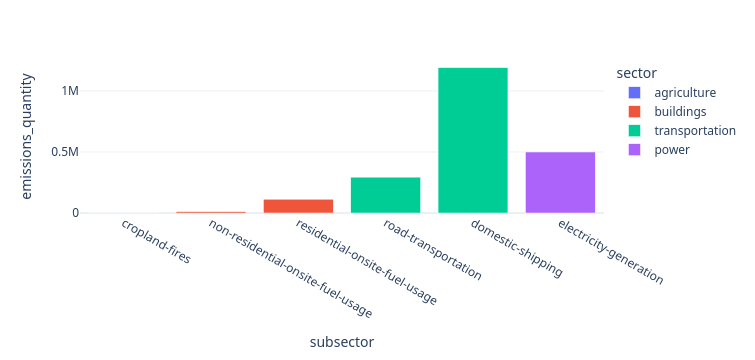

In [77]:
import plotly.io
plotly.io.templates.default = "plotly_white"
import plotly.express as px

px.bar(
gadm_biz_data.filter(c_year == 2024).sort(by=c_emissions_quantity),
    x="subsector",
    y="emissions_quantity",
    color="sector"
)


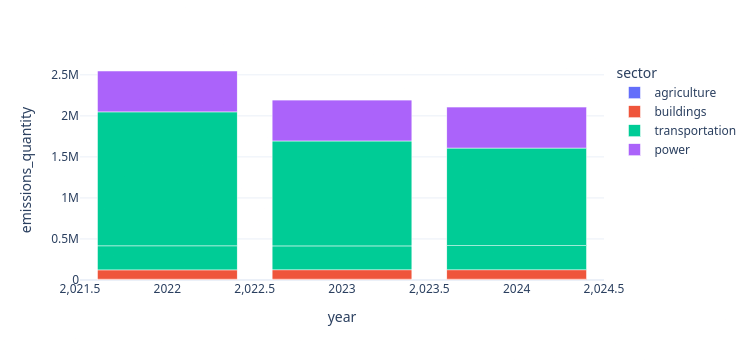

In [78]:
px.bar(
gadm_biz_data.sort(by=c_emissions_quantity),
    x="year",
    y="emissions_quantity",
    color="sector"
)

In [79]:
raise

RuntimeError: No active exception to reraise

## Creating optimized parquet files for source data

This first section creates files that are the most effective for reading and querying. The general approach is as follows:

1. Join the source and source confidence CSV files and writes them as parquet files for each subsector
2. Aggregate by year into a yearly parquet file
3. Optimize this parquet file for reading

This first command creates parquet files that join the source and source confidences for each subsector, and returns a list of all the created files.

In this notebook, another trick is to define the transformations as _data functions_. In short, this code will only run if the source code changes. This makes rerunning the notebooks very fast, and only updating when something has changed in the source code.

In [ ]:
@data_function("/data_sources")
def load_sources():
    (_, files) = ct.data.load_source_compact()
    return files

load_sources()

To help with the loading, the data is partitioned by year. This is the most relevant for most users: most people are expected to look at specific years and sectors (especially the latest year). This reduces the amount of data to load.

Let us have a quick peek at the data in one of these files. It looks already pretty good: a lot of the redundant data such as the enumerations has been deduplicated. All the enumeration data is now converted to integers, this is what `dictionary<values=string, indices=int32, ordered=0>` means. It is not quite ready for high performance however.

In [ ]:
from pyarrow.parquet import read_table
fname = load_sources()[0]
print(fname)
read_table(fname)

## Aggregating by year and optimizing the output

The following block takes all the sector files and aggregates them by year. This is based on the expectation that most users will work on the latest year, and that some users will want to look into the trends across the years.

Since these files will be read many times (every time we want to do a graph), it pays off to optimize them. The Parquet format is designed for fast reads of the relevant data. We will do two main optimizations: optimal compression, optimizing the row groups and adding statistics.



_Compression_ Parquet allows some data to be compressed by columns. The first intuition is that, looking at each column of data separately, there will be more patterns and thus more opportunities to compress the data. The second intuition is that, in data-intensive application, reading the data is the bottleneck. It is then faster to read smaller compressed data in memory and then decompress it (losing a bit of time in compute), rather than reading larger, uncompressed data. Modern compression algorithms such as ZStandard or LZ4 are designed to be very effective at using a processor. Using them is essentially a pure gain in terms of processing speed.


```{admonition} CTODO
The year of a data record is defined by its start time. This may be different than the convention used by Climate Trace. To check.
```


In [ ]:
write_directory = "/tmp"
years = ct.data.years
version = ct.data.version
gases = ct.constants.GAS_LIST

@data_function("/write_data")
def write_data():
    data_files = load_sources()
    dfs = []
    for tmp_name in data_files:
        print(tmp_name)
        df = pl.scan_parquet(tmp_name)
        df = df.pipe(ct.data.recast_parquet, conf=True)
        dfs.append(df)
    ldf = pl.concat(dfs)
    fnames = []
    for gas in gases:
        for year in years:
            fname1 = f"{write_directory}/pre_climate_trace-sources_{version}_{year}_{gas}.parquet"
            (
                ldf.filter(c_start_time.dt.year() == int(year))
                   .filter(c_gas == gas)
                   .sort(by=[GAS, SECTOR, SUBSECTOR, ISO3_COUNTRY, SOURCE_ID])
                   .sink_parquet(
                    fname1,
                    compression="zstd",
                    maintain_order=True,
                    statistics=True,
                )
            )
            fname = f"{write_directory}/climate_trace-sources_{version}_{year}_{gas}.parquet"
            print(fname)
            ds = pyarrow.dataset.dataset(fname1)
            pyarrow.dataset.write_dataset(
                ds,
                base_dir="/tmp",
                basename_template="ds_{i}.parquet",
                format="parquet",
                partitioning=None,
                min_rows_per_group=300_000,
                max_rows_per_group=1_000_000,
            )
            shutil.copyfile("/tmp/ds_0.parquet", fname)
            fnames.append((fname1, fname))
    return fnames

write_data()

_Optimizing row groups_ A parquet file is a collection of groups of rows, and these rows are organized column-wise along with some statistics. We can choose how many groups to create: the minimum is one group (all the data into a single group), which is the most standard. This is not optimal however: reading can only be done by one processor core at a time. If we have more, they will sit idle. This is why it is better to choose the number of groups to be close to the expected number of processor cores (10-100). When reading, each core will process a different chunk of the file in parallel.

Polars cannot do this yet, so the code below directly calls the `pyarrow` package to restructure the final file, calling the function `pyarrow.dataset.write_dataset`. 

Here is the parquet files produced directly by Polars. It is the result of joining datasets which themselves are the result of reading many files (each by subsector). It is very fragmented (see the `num_row_groups` statistics below).


In [ ]:
(fname_pre, fname_post) = write_data()[0]
print(fname_pre)
print(fname_post)
parquet_file = pyarrow.parquet.ParquetFile(fname_pre)
# print(parquet_file.metadata.row_group(0).column(2).statistics)
parquet_file.metadata

The final file is more compact: only 58 row groups. It will be much faster to read (up to 50 times faster on my computer) because the readers do not need to gather information from each of the row groups.

In [ ]:
parquet_file = pyarrow.parquet.ParquetFile(fname_post)
parquet_file.metadata

_Statistics_ Each row group in a parquet file has statistics. These statistics contain for each columns basic information such as minimum, maximum, etc. as you can see below. During a query, a data system first reads these statistics to check what blocks of data it should read. 

For example, the first row group only contains agriculture data (which you can infer from `min: agriculture` and `max: agriculture`). As the result, if a query is looking for waste data, it can safely skip this full block. 

Grouping the rows and creating statistics can dramatically reduce the amount of data being read and processed. Finding the right number of groups is a tradeoff between using more cores to read the data in parallel, and not having to read too many statistics descriptions. In the extreme case of the file created by Polars (5000 row groups), the statistics make up 40% of the file and can take up to 90% of the processing time! If your parquet file reads slowly, it is probably due to its internal layout.

In [ ]:
parquet_file = pyarrow.parquet.ParquetFile(fname_post)
parquet_file.metadata.row_group(0).column(12).statistics

## Initial checks

We know check that it works correctly. Let's load the newly created data instead of the default version stored on the internet, for the year 2023.

In [ ]:
sdf = ct.read_source_emissions(gas=CO2, year=2023, p="/tmp")
sdf

About 15M records for this year. This is spread across multiple gas and also multiple trips in the case of boats or airplanes.

In [ ]:
sdf.select(pl.len()).collect()

Check the number of distinct source IDs

In [ ]:
by_sec = (sdf
.group_by(SOURCE_ID, SECTOR)
.agg(pl.len())
.collect())

The number of sources outside forestry and land use:

In [ ]:
by_sec.filter(c_sector != FORESTRY_AND_LAND_USE).select(pl.len())

Check: no source is associated with multiple sectors.

In [ ]:
by_sec.group_by(SOURCE_ID).agg(c_sector.n_unique()).filter(pl.col(SECTOR) > 1)

Check: no annual source should be duplicated by gas. It used to be the case with V2 release.

In [ ]:
(sdf
.filter(c_temporal_granularity =="annual")
.group_by(SOURCE_ID, GAS)
.agg(pl.len())
.filter(pl.col("len") > 1)
.sort(by="len")
.collect())

Check: emissions should always be defined. V2 used to have empty values.

In [ ]:
sdf = ct.read_source_emissions(CO2E_100YR, 2023, "/tmp")
(sdf
 .select(c_emissions_quantity.is_null().alias("null_emissions"), c_subsector, c_iso3_country)
 .group_by(c_subsector, "null_emissions")
 .agg(pl.len())
 .collect()
 .pivot(index=SUBSECTOR, on="null_emissions", values="len")
)

## Integrity checks

Before uploading and publishing data, it is a good idea to run a number of checks. Frameworks such as [pandera](https://pandera.readthedocs.io/en/latest/polars.html) are very helpful to implement these checks. Here we just check that Akrotiri and Dhekelia (country code XAD) is not included, as mentioned in the documentation.

In [ ]:
(ct.read_source_emissions(gas=GAS_LIST, year=2022, p="/tmp")
 .filter(c_iso3_country == "XAD")
 .select(pl.len())
.collect())

### CO2e subsector data should be a superset of all sectors

Here is an example of issue to investigate: one would expect the total CO2e_100yr (total emissions normalized by their CO2 equivalent) to be at least present for each sector in which emissions are reported. This is not the case for FLU, for instance for the `removals` subsector.

```{admonition} CTODO
:name: missing-co2e-subsectors
Confirm with CT.
```

In [ ]:
with pl.Config(tbl_rows=20):
    print(ct.read_source_emissions(gas=GAS_LIST, year=2022, p="/tmp")
     .group_by(c_sector, c_subsector, c_gas)
     .agg(c_emissions_quantity.sum())
     #.filter(c_emissions_quantity < 0)
     .sort(by=[c_sector, c_subsector, c_gas])
     .collect()
     .pivot(GAS, index=[SECTOR, SUBSECTOR])
     .filter(pl.col(CO2E_100YR).is_null())
     .filter(pl.col(CO2) != 0)
    )

## Create parquet files for country emissions

As of V3, country emission data is also large enough that it should be compacted in parquet files. Note the dramatic difference:

- uncompressed CSV file: 106MB
- compressed CSV file: 6MB
- parquet: 1MB !!

As highlighted, the parquet file also has the advantage of being very efficient at extracting only the relevant information.

In [ ]:
# Starting from the official archives, read all the gases.

@data_function("/read_country")
def read_country():
    path = Path(tempfile.gettempdir()) / f"climate-trace-countries-{ct.data.version}.parquet"
    print(path)
    cdf = ct.read_country_emissions(ct.constants.GAS_LIST, archive_path=True)
    # Optimizing to read by time and then gas.
    # The logic being that country-specific files are already available from CT.
    (cdf
     .sort(by=[c_start_time,c_gas,c_iso3_country])
      .write_parquet(path) # Not taking precautions, the file is so small.
    )
    return path

p = read_country()

## Contry emissions: integrity checks

In a production pipeline, before uploading the final data, we would run a number of checks again on the country emissions. Here are a few checks that we can run (and which are currently failing).

In [ ]:
cdf = ct.read_country_emissions(parquet_path=p)
cdf.head(2)

### Country emissions: CO2e data should be a superset of all country emissions

We see that some subsectors are present in CO2 emissions but are missing in the aggregated CO2e emissions

In [ ]:
with pl.Config(tbl_rows=20):
    print(cdf
     .group_by(c_sector, c_subsector, c_gas)
     .agg(c_emissions_quantity.sum())
     .sort(by=[c_sector, c_subsector, c_gas])
     .pivot(GAS, index=[SECTOR, SUBSECTOR])
     .filter(pl.col(CO2E_100YR).is_null())
     .filter(pl.col(CO2) != 0)
    )

### Country emissions: some countries are excluded from the dataset

The Climate TRACE documentation excludes certain countries from the final release, but they are still present in the dataset:

In [ ]:
excluded_isos = ["XAD", "XCL", "XPI", "XSP"]
(cdf
 .filter(c_iso3_country.is_in(excluded_isos))
 .group_by([ISO3_COUNTRY, c_start_time.dt.year(), GAS, SECTOR, SUBSECTOR])
 .agg(pl.len()))

## Upload the data to the Hugging Face Hub

As a final step, we make the datasets available on Hugging Face as a downloadable dataset.

This step will only work if you have the credentials to upload the dataset.

In [ ]:
import huggingface_hub.utils
upload = False
if upload:
    try:
        api = huggingface_hub.HfApi()
        for (_, fpath) in write_data():
            fname = os.path.basename(fpath)
            print(fname, fpath)
            api.upload_file(
                path_or_fileobj=fpath,
                path_in_repo=fname,
                repo_id="tjhunter/climate-trace",
                repo_type="dataset",
            )
        fpath = read_country()
        fname = os.path.basename(fpath)
        print(fname, fpath)
        api.upload_file(
            path_or_fileobj=fpath,
            path_in_repo=fname,
            repo_id="tjhunter/climate-trace",
            repo_type="dataset",
        )
    except huggingface_hub.utils.HfHubHTTPError as e:
        print("error")
        print(e)